pip install transformers datasets tqdm torch


In [1]:
import torch
print(torch.__version__)

2.5.1+cu124


In [2]:
import datasets
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import json


In [3]:
import json

# Open and read the JSON files
with open('train_dataset.json', 'r') as file:
    train_data = json.load(file)

with open('test_dataset.json', 'r') as file:
    test_data = json.load(file)

with open('eval_dataset.json', 'r') as file:
    eval_data = json.load(file)


In [4]:
len(train_data)

263988

In [5]:
# Convert the list of dictionaries into a dictionary of lists
formatted_train_data = {
    "context": [item["context"] for item in train_data],
    "question": [item["question"] for item in train_data],
    "answers": [item["answer"] for item in train_data],
}

# Create a Hugging Face dataset
train_dataset = Dataset.from_dict(formatted_train_data)

In [6]:
# same for test dataset
formatted_test_data = {
    "context": [item["context"] for item in test_data],
    "question": [item["question"] for item in test_data],
    "answers": [item["answer"] for item in test_data],
}

# Create a Hugging Face dataset
test_dataset = Dataset.from_dict(formatted_test_data)

In [7]:
# same for test dataset
formatted_eval_data = {
    "context": [item["context"] for item in eval_data],
    "question": [item["question"] for item in eval_data],
    "answers": [item["answer"] for item in eval_data],
}

# Create a Hugging Face dataset
eval_dataset = Dataset.from_dict(formatted_eval_data)

In [8]:
tiny_dataset = Dataset.from_dict(eval_dataset[:10])

In [9]:
tiny_dataset

Dataset({
    features: ['context', 'question', 'answers'],
    num_rows: 10
})

In [10]:
import torch
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Load a pre-trained model
model_name = "bert-base-uncased"
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Move the model to GPU (optional, Trainer handles this automatically if GPU is available)
model = model.to(device)


cuda


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/storage/homefs/alibert/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
from transformers import Trainer

def compute_loss(model, inputs, return_outputs=False):
    # Forward pass
    outputs = model(**inputs)
    start_positions = inputs.get('start_positions')
    end_positions = inputs.get('end_positions')
    
    # Compute loss
    start_loss = outputs.loss[0]  # Start token loss
    end_loss = outputs.loss[1]    # End token loss
    
    # You can log both losses if needed
    total_loss = start_loss + end_loss
    
    if return_outputs:
        return total_loss, outputs
    return total_loss


In [12]:
import numpy as np
def preprocess_function(example):
    # Tokenize the question and context
    tokenized = tokenizer(
        example["question"],
        example["context"],
        truncation=True,
        padding="max_length",
        max_length=384,
        return_offsets_mapping=True,
        return_token_type_ids=True  # Get token_type_ids to distinguish between question and context
    )
    input_ids = tokenized["input_ids"]
    offsets = tokenized["offset_mapping"]
    token_type_ids = tokenized["token_type_ids"]
    first_context_token_ID = [
        row.index(1) if 1 in row else -1  # Use -1 to indicate no occurrence of 1
        for row in token_type_ids
        ]
    
    # Find start and end character positions in the context
    list_start_char = []
    list_end_char = []
    for ans in example["answers"]:
        list_start_char.append(ans["start"])
        list_end_char.append(ans["end"])

    # Initialize lists to store start and end token indices for valid examples
    valid_start_tokens = []
    valid_end_tokens = []

    # Loop over the batch
    for batch_idx in range(len(offsets)):
        context_first_token_position = first_context_token_ID[batch_idx]  # Offsets for the current context
        context_first_char_position = offsets[batch_idx][context_first_token_position-2][1]
        start_char = list_start_char[batch_idx]  # Start character for this example
        end_char = list_end_char[batch_idx]      # End character for this example
        # Initialize start and end tokens for this example
        start_token = None
        end_token = None

        # Focus on context tokens only (where token_type_id is 1)
        for idx, (start_offset, end_offset) in enumerate(offsets[batch_idx][context_first_token_position-1:]):
            if start_offset <= start_char < end_offset:
                start_token = idx+context_first_token_position-1
            if start_offset < end_char <= end_offset:
                end_token = idx+context_first_token_position
                break
                    
        # If valid start and end tokens are found, add them to the lists
        if start_token is not None and end_token is not None:
            valid_start_tokens.append(start_token)
            valid_end_tokens.append(end_token)
        else:
            print('problem finding start and end tokens')
            valid_start_tokens.append(None)
            valid_end_tokens.append(None)
            print(example["context"][batch_idx])
            print(example["question"][batch_idx])
            print(example["answers"][batch_idx])


    # Add valid start and end positions to the tokenized output
    tokenized["start_positions"] = valid_start_tokens
    tokenized["end_positions"] = valid_end_tokens

        
    # Remove the offset mapping to save memory
    tokenized.pop("offset_mapping", None)
    tokenized.pop("token_type_ids", None)
        
    list_int = []
    list_att = []
    list_start = []
    list_end = []
    list_context = []
    list_question = []
    list_answers = []
    for tok_context,tok_question,tok_answers,tok_input,tok_att,tok_start,tok_end in zip(example["context"],example["question"],example["answers"],tokenized['input_ids'],tokenized['attention_mask'],tokenized['start_positions'],tokenized['end_positions']):
        if (tok_start != None ) and ( tok_end != None):
            list_int.append(tok_input)
            list_att.append(tok_att)
            list_start.append(tok_start)
            list_end.append(tok_end)
            list_context.append(tok_context)
            list_question.append(tok_question)
            list_answers.append(tok_answers)
            
    return {'context':list_context, 'question':list_question, 'answers':list_answers, 'input_ids':list_int, 'attention_mask':list_att, 'start_positions':list_start, 'end_positions':list_end}




In [13]:
tokenized_train_datasets = train_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/263988 [00:00<?, ? examples/s]

problem finding start and end tokens
Understanding the impact of prior mass and orbit information on planetary characterization is crucial for efficiently recognizing habitable exoplanets. To address this question, we use a reflected-light retrieval tool to infer the atmospheric and bulk properties of directly imaged Earth-analogs while considering varying levels of prior information and signal-to-noise ratio (S/N). Because of the strong correlation between the orbit-related parameters and the planetary radius, prior information on the orbital distance and planetary phase angle yield much tighter constraints on the planetary radius: from <inline-formula> <mml:math overflow="scroll"><mml:msub><mml:mrow><mml:mi>R</mml:mi></mml:mrow><mml:mrow><mml:mi mathvariant="normal">p</mml:mi></mml:mrow></mml:msub><mml:mo>=</mml:mo><mml:msubsup><mml:mrow><mml:mn>2.95</mml:mn></mml:mrow><mml:mrow><mml:mo>‑</mml:mo><mml:mn>1.95</mml:mn></mml:mrow><mml:mrow><mml:mo>+</mml:mo><mml:mn>2.69</mml:mn></mml:m

In [14]:
tokenized_train_datasets

Dataset({
    features: ['context', 'question', 'answers', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 263867
})

In [15]:
tokenized_test_datasets = test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/32946 [00:00<?, ? examples/s]

problem finding start and end tokens
We critically discuss the actual measurability of the mixed effects with respect to direct ones. The current uncertainties in either the magnitude of the Sun's angular momentum <inline-formula id="IEq4"><mml:math><mml:msub><mml:mi>S</mml:mi><mml:mo>⊙</mml:mo></mml:msub></mml:math></inline-formula> and the orientation of its spin axis <inline-formula id="IEq5"><mml:math><mml:msub><mml:mrow><mml:mover accent="true"><mml:mi mathvariant="bold-italic">S</mml:mi><mml:mo mathvariant="bold" stretchy="false">^</mml:mo></mml:mover></mml:mrow><mml:mo>⊙</mml:mo></mml:msub></mml:math></inline-formula> impact the precessions <inline-formula id="IEq6"><mml:math><mml:mrow><mml:msub><mml:mover accent="true"><mml:mi>ϖ</mml:mi><mml:mo>˙</mml:mo></mml:mover><mml:msubsup><mml:mi>J</mml:mi><mml:mn>2</mml:mn><mml:mo>⊙</mml:mo></mml:msubsup></mml:msub><mml:mo>,</mml:mo><mml:mspace width="3.33333pt"></mml:mspace><mml:msub><mml:mover accent="true"><mml:mi>ϖ</mml:mi><mml:mo>˙

In [16]:
tokenized_eval_datasets = eval_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/32931 [00:00<?, ? examples/s]

problem finding start and end tokens
This model depends upon only two dimensionless parameters that control the dynamics of the system: the distance <inline-formula id="IEq13"><mml:math><mml:mi>D</mml:mi></mml:math></inline-formula> between the CER and LER, and a forcing parameter <inline-formula id="IEq14"><mml:math><mml:msub><mml:mi mathvariant="italic">ϵ</mml:mi><mml:mi>L</mml:mi></mml:msub></mml:math></inline-formula> that includes both the mass and the orbital eccentricity of the disturbing satellite. Three regimes are found: for <inline-formula id="IEq15"><mml:math><mml:mrow><mml:mi>D</mml:mi><mml:mo>=</mml:mo><mml:mn>0</mml:mn></mml:mrow></mml:math></inline-formula> the system is integrable, for <inline-formula id="IEq16"><mml:math><mml:mi>D</mml:mi></mml:math></inline-formula> of order unity, it exhibits prominent chaotic regions, while for <inline-formula id="IEq17"><mml:math><mml:mi>D</mml:mi></mml:math></inline-formula> large compared to 2, the behavior of the system is regu

In [25]:
# Create DataLoader
from transformers import default_data_collator
from torch.utils.data import DataLoader

# Define the columns to retain
columns_to_keep = ['input_ids', 'attention_mask', 'start_positions', 'end_positions']

batch_size = 32


# Filter dataset to keep only the specified columns
filtered_train_datasets = tokenized_train_datasets.remove_columns(
    [col for col in tokenized_train_datasets.column_names if col not in columns_to_keep]
)
train_dataloader = DataLoader(
    filtered_train_datasets,
    batch_size=batch_size,  # Adjust based on available memory
    shuffle=False,
    collate_fn=default_data_collator,  # Ensures correct batching
)


# Filter dataset to keep only the specified columns
filtered_eval_datasets = tokenized_eval_datasets.remove_columns(
    [col for col in tokenized_eval_datasets.column_names if col not in columns_to_keep]
)
eval_dataloader = DataLoader(
    filtered_eval_datasets,
    batch_size=batch_size,  # Adjust based on available memory
    shuffle=False,
    collate_fn=default_data_collator,  # Ensures correct batching
)

# Filter dataset to keep only the specified columns
filtered_test_datasets = tokenized_test_datasets.remove_columns(
    [col for col in tokenized_test_datasets.column_names if col not in columns_to_keep]
)
test_dataloader = DataLoader(
    filtered_test_datasets,
    batch_size=batch_size,  # Adjust based on available memory
    shuffle=False,
    collate_fn=default_data_collator,  # Ensures correct batching
)


In [18]:
from tqdm import tqdm

# Training loop
model.train()  # Set model to training mode
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)  # Define optimizer
loss_fn = torch.nn.CrossEntropyLoss()  # Define loss function

list_train_loss = []
list_eval_loss = []

import os

# **Specify paths for saving models**
output_dir = "saved_models/"
os.makedirs(output_dir, exist_ok=True)

n_epochs = 10
nstep = 0
eval_steps = 1000
train_loss = 0
best_eval_loss = float("inf")  # **Track the best evaluation loss**

for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    total_loss = 0

    for batch in tqdm(train_dataloader, desc="Training"):
        nstep += 1
        # Move batch to the appropriate device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(**batch)
        
        # Compute the loss
        start_loss = loss_fn(outputs.start_logits, batch["start_positions"])
        end_loss = loss_fn(outputs.end_logits, batch["end_positions"])
        loss = (start_loss + end_loss) / 2
        
        # Backward pass
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()
        train_loss += loss.item()
        
        # Save the model every eval_steps steps
        if nstep % eval_steps == 0:
            save_path = os.path.join(output_dir, f"checkpoint_epoch_step_{nstep}")
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)  # Save tokenizer
            print(f"Model checkpoint saved at step {nstep} to {save_path}")

        if nstep % eval_steps  == 0:
            with torch.no_grad():
                model.eval()  # 
                eval_loss = 0
                for batch in eval_dataloader:
                    # Move batch to the appropriate device
                    batch = {k: v.to(device) for k, v in batch.items()}
        
                    # Forward pass
                    outputs = model(**batch)
        
                    # Compute the loss
                    start_loss = loss_fn(outputs.start_logits, batch["start_positions"])
                    end_loss = loss_fn(outputs.end_logits, batch["end_positions"])
                    eval_loss += (start_loss + end_loss) / 2
            
                eval_loss = eval_loss/len(eval_dataloader)
                
                print('TRAIN - EVAL LOSS',train_loss/(eval_steps),eval_loss.item())
                list_train_loss.append(train_loss/eval_steps)
                list_eval_loss.append(eval_loss.item())
            # Save the best model
            if eval_loss < best_eval_loss:
                best_eval_loss = eval_loss
                best_model_path = os.path.join(output_dir, "best_model")
                model.save_pretrained(best_model_path)
                tokenizer.save_pretrained(best_model_path)
                print(f"Best model saved with eval loss {best_eval_loss:.4f} to {best_model_path}")          
            
            model.train()
            train_loss = 0           
            

    # Print epoch loss
    avg_loss = total_loss / len(train_dataloader)
    print(f"Average training loss for epoch {epoch + 1}: {avg_loss:.4f}")

# Save the best model at the end of training
best_model_path = os.path.join(output_dir, "final_best_model")
model.save_pretrained(best_model_path)
tokenizer.save_pretrained(best_model_path)
print(f"Final best model saved to {best_model_path}")
    
print("Training complete!")


Epoch 1/10


Training:  12%|█▏        | 999/8246 [03:53<28:16,  4.27it/s]

Model checkpoint saved at step 1000 to saved_models/checkpoint_epoch_step_1000
TRAIN - EVAL LOSS 2.0485948407053947 1.4315003156661987


Training:  12%|█▏        | 1000/8246 [05:06<44:24:55, 22.07s/it]

Best model saved with eval loss 1.4315 to saved_models/best_model


Training:  24%|██▍       | 1999/8246 [08:59<24:18,  4.28it/s]   

Model checkpoint saved at step 2000 to saved_models/checkpoint_epoch_step_2000
TRAIN - EVAL LOSS 1.3856001272797585 1.2005064487457275


Training:  24%|██▍       | 2000/8246 [10:12<38:16:27, 22.06s/it]

Best model saved with eval loss 1.2005 to saved_models/best_model


Training:  36%|███▋      | 2999/8246 [14:06<20:24,  4.28it/s]   

Model checkpoint saved at step 3000 to saved_models/checkpoint_epoch_step_3000
TRAIN - EVAL LOSS 1.2783680037558078 1.1352324485778809


Training:  36%|███▋      | 3000/8246 [15:23<34:03:13, 23.37s/it]

Best model saved with eval loss 1.1352 to saved_models/best_model


Training:  48%|████▊     | 3999/8246 [19:16<16:31,  4.28it/s]   

Model checkpoint saved at step 4000 to saved_models/checkpoint_epoch_step_4000
TRAIN - EVAL LOSS 1.1883949423134328 1.0907541513442993


Training:  49%|████▊     | 4000/8246 [20:29<25:59:14, 22.03s/it]

Best model saved with eval loss 1.0908 to saved_models/best_model


Training:  61%|██████    | 4999/8246 [24:23<12:37,  4.28it/s]   

Model checkpoint saved at step 5000 to saved_models/checkpoint_epoch_step_5000
TRAIN - EVAL LOSS 1.1354878900349141 1.0593421459197998


Training:  61%|██████    | 5000/8246 [25:35<19:51:06, 22.02s/it]

Best model saved with eval loss 1.0593 to saved_models/best_model


Training:  73%|███████▎  | 5999/8246 [29:29<08:44,  4.28it/s]   

Model checkpoint saved at step 6000 to saved_models/checkpoint_epoch_step_6000
TRAIN - EVAL LOSS 1.0938166062235832 1.0162845849990845


Training:  73%|███████▎  | 6000/8246 [30:42<13:43:55, 22.01s/it]

Best model saved with eval loss 1.0163 to saved_models/best_model


Training:  85%|████████▍ | 6999/8246 [34:35<04:51,  4.28it/s]   

Model checkpoint saved at step 7000 to saved_models/checkpoint_epoch_step_7000
TRAIN - EVAL LOSS 1.0879243093430997 0.9921079277992249


Training:  85%|████████▍ | 7000/8246 [35:48<7:37:12, 22.02s/it]

Best model saved with eval loss 0.9921 to saved_models/best_model


Training:  97%|█████████▋| 7999/8246 [39:41<00:57,  4.28it/s]  

Model checkpoint saved at step 8000 to saved_models/checkpoint_epoch_step_8000
TRAIN - EVAL LOSS 1.0534675041139125 0.972833514213562


Training:  97%|█████████▋| 8000/8246 [40:54<1:30:18, 22.03s/it]

Best model saved with eval loss 0.9728 to saved_models/best_model


Training: 100%|██████████| 8246/8246 [41:52<00:00,  3.28it/s]  


Average training loss for epoch 1: 1.2770
Epoch 2/10


Training:   9%|▉         | 753/8246 [02:55<29:09,  4.28it/s]

Model checkpoint saved at step 9000 to saved_models/checkpoint_epoch_step_9000
TRAIN - EVAL LOSS 0.9938195230066776 0.9603407979011536


Training:   9%|▉         | 754/8246 [04:08<45:50:21, 22.03s/it]

Best model saved with eval loss 0.9603 to saved_models/best_model


Training:  21%|██▏       | 1753/8246 [08:01<25:14,  4.29it/s]  

Model checkpoint saved at step 10000 to saved_models/checkpoint_epoch_step_10000


Training:  21%|██▏       | 1754/8246 [09:14<39:27:24, 21.88s/it]

TRAIN - EVAL LOSS 0.8878684822916985 0.9994011521339417


Training:  33%|███▎      | 2753/8246 [13:07<21:20,  4.29it/s]   

Model checkpoint saved at step 11000 to saved_models/checkpoint_epoch_step_11000


Training:  33%|███▎      | 2754/8246 [14:19<33:23:38, 21.89s/it]

TRAIN - EVAL LOSS 0.8646578141748905 0.9903460144996643


Training:  46%|████▌     | 3753/8246 [18:12<17:27,  4.29it/s]   

Model checkpoint saved at step 12000 to saved_models/checkpoint_epoch_step_12000


Training:  46%|████▌     | 3754/8246 [19:25<27:20:30, 21.91s/it]

TRAIN - EVAL LOSS 0.819387237071991 0.9748220443725586


Training:  58%|█████▊    | 4753/8246 [23:18<13:34,  4.29it/s]   

Model checkpoint saved at step 13000 to saved_models/checkpoint_epoch_step_13000


Training:  58%|█████▊    | 4754/8246 [24:30<21:13:49, 21.89s/it]

TRAIN - EVAL LOSS 0.8081359226703644 0.9814939498901367


Training:  70%|██████▉   | 5753/8246 [28:23<09:41,  4.29it/s]   

Model checkpoint saved at step 14000 to saved_models/checkpoint_epoch_step_14000


Training:  70%|██████▉   | 5754/8246 [29:36<15:09:10, 21.89s/it]

TRAIN - EVAL LOSS 0.7792916500419378 1.0030021667480469


Training:  82%|████████▏ | 6753/8246 [33:29<05:48,  4.28it/s]   

Model checkpoint saved at step 15000 to saved_models/checkpoint_epoch_step_15000


Training:  82%|████████▏ | 6754/8246 [34:41<9:04:27, 21.90s/it]

TRAIN - EVAL LOSS 0.7688517838418484 0.9698235392570496


Training:  94%|█████████▍| 7753/8246 [38:34<01:54,  4.29it/s]  

Model checkpoint saved at step 16000 to saved_models/checkpoint_epoch_step_16000


Training:  94%|█████████▍| 7754/8246 [39:47<2:59:30, 21.89s/it]

TRAIN - EVAL LOSS 0.7638141993880272 0.9741408228874207


Training: 100%|██████████| 8246/8246 [41:42<00:00,  3.30it/s]  


Average training loss for epoch 2: 0.8239
Epoch 3/10


Training:   6%|▌         | 507/8246 [01:58<30:05,  4.29it/s]

Model checkpoint saved at step 17000 to saved_models/checkpoint_epoch_step_17000


Training:   6%|▌         | 508/8246 [03:10<47:06:05, 21.91s/it]

TRAIN - EVAL LOSS 0.7234455206096172 0.995719850063324


Training:  18%|█▊        | 1507/8246 [07:03<26:11,  4.29it/s]  

Model checkpoint saved at step 18000 to saved_models/checkpoint_epoch_step_18000


Training:  18%|█▊        | 1508/8246 [08:16<41:00:06, 21.91s/it]

TRAIN - EVAL LOSS 0.6506812665611506 0.9917624592781067


Training:  30%|███       | 2507/8246 [12:09<22:18,  4.29it/s]   

Model checkpoint saved at step 19000 to saved_models/checkpoint_epoch_step_19000


Training:  30%|███       | 2508/8246 [13:21<34:53:47, 21.89s/it]

TRAIN - EVAL LOSS 0.6260324829071761 1.048353672027588


Training:  43%|████▎     | 3507/8246 [17:14<18:26,  4.28it/s]   

Model checkpoint saved at step 20000 to saved_models/checkpoint_epoch_step_20000


Training:  43%|████▎     | 3508/8246 [18:27<28:48:17, 21.89s/it]

TRAIN - EVAL LOSS 0.5891264231950044 1.0970600843429565


Training:  55%|█████▍    | 4507/8246 [22:20<14:31,  4.29it/s]   

Model checkpoint saved at step 21000 to saved_models/checkpoint_epoch_step_21000


Training:  55%|█████▍    | 4508/8246 [23:32<22:43:47, 21.89s/it]

TRAIN - EVAL LOSS 0.5877770073711872 1.0218428373336792


Training:  67%|██████▋   | 5507/8246 [27:25<10:39,  4.29it/s]   

Model checkpoint saved at step 22000 to saved_models/checkpoint_epoch_step_22000


Training:  67%|██████▋   | 5508/8246 [28:38<16:39:28, 21.90s/it]

TRAIN - EVAL LOSS 0.5695890448391437 1.0858790874481201


Training:  79%|███████▉  | 6507/8246 [32:30<06:45,  4.29it/s]   

Model checkpoint saved at step 23000 to saved_models/checkpoint_epoch_step_23000


Training:  79%|███████▉  | 6508/8246 [33:43<10:34:40, 21.91s/it]

TRAIN - EVAL LOSS 0.5495386467427015 1.0621824264526367


Training:  91%|█████████ | 7507/8246 [37:36<02:52,  4.29it/s]   

Model checkpoint saved at step 24000 to saved_models/checkpoint_epoch_step_24000


Training:  91%|█████████ | 7508/8246 [38:49<4:29:12, 21.89s/it]

TRAIN - EVAL LOSS 0.5586548758447171 1.064864158630371


Training: 100%|██████████| 8246/8246 [41:41<00:00,  3.30it/s]  


Average training loss for epoch 3: 0.5937
Epoch 4/10


Training:   3%|▎         | 261/8246 [01:00<31:02,  4.29it/s]

Model checkpoint saved at step 25000 to saved_models/checkpoint_epoch_step_25000


Training:   3%|▎         | 262/8246 [02:13<48:33:40, 21.90s/it]

TRAIN - EVAL LOSS 0.5460124764889479 1.0920289754867554


Training:  15%|█▌        | 1261/8246 [06:06<27:09,  4.29it/s]  

Model checkpoint saved at step 26000 to saved_models/checkpoint_epoch_step_26000


Training:  15%|█▌        | 1262/8246 [07:18<42:29:13, 21.90s/it]

TRAIN - EVAL LOSS 0.49130297495424746 1.1376724243164062


Training:  27%|██▋       | 2261/8246 [11:11<23:15,  4.29it/s]   

Model checkpoint saved at step 27000 to saved_models/checkpoint_epoch_step_27000


Training:  27%|██▋       | 2262/8246 [12:24<36:24:36, 21.90s/it]

TRAIN - EVAL LOSS 0.46232806831598283 1.1571472883224487


Training:  40%|███▉      | 3261/8246 [16:17<19:22,  4.29it/s]   

Model checkpoint saved at step 28000 to saved_models/checkpoint_epoch_step_28000


Training:  40%|███▉      | 3262/8246 [17:29<30:19:17, 21.90s/it]

TRAIN - EVAL LOSS 0.4465720360726118 1.1755887269973755


Training:  52%|█████▏    | 4261/8246 [21:22<15:29,  4.29it/s]   

Model checkpoint saved at step 29000 to saved_models/checkpoint_epoch_step_29000


Training:  52%|█████▏    | 4262/8246 [22:35<24:14:15, 21.90s/it]

TRAIN - EVAL LOSS 0.44709348276257516 1.1591696739196777


Training:  62%|██████▏   | 5107/8246 [25:52<15:54,  3.29it/s]   


KeyboardInterrupt: 

In [19]:
np.save('training_loss.npy',np.array(list_train_loss))

In [20]:
np.save('eval_loss.npy',np.array(list_eval_loss))

In [21]:
import matplotlib.pyplot as plt

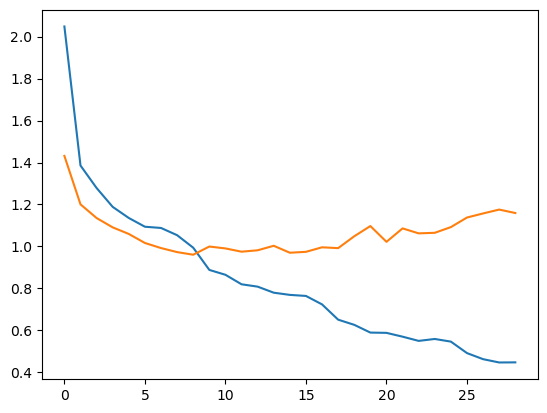

In [22]:
plt.plot(list_train_loss)
plt.plot(list_eval_loss)

In [71]:

from transformers import AutoModelForQuestionAnswering, AutoTokenizer

# Path to the directory where the best model is saved
best_model_path = "saved_models/best_model"

# Reload the model and tokenizer
model = AutoModelForQuestionAnswering.from_pretrained(best_model_path)
model.to(device)
# Ensure the model is in evaluation mode

model.eval()  # 

truth_start = []
truth_end = []
pred_start = []
pred_end = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
    # Move batch to the appropriate device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(**batch)
        
        # Compute the loss
        start_list = batch["start_positions"]
        end_list = batch["end_positions"]
        for i,(start,end) in enumerate(zip(start_list,end_list)):
            truth_start.append(start.item())
            truth_end.append(end.item())   

        start_list =  torch.argmax(outputs.start_logits,dim=1)
        end_list = torch.argmax(outputs.end_logits,dim=1)
        for i,(start,end) in enumerate(zip(start_list,end_list)):
            pred_start.append(start.item())
            pred_end.append(end.item())   
        
        


100%|██████████| 1030/1030 [01:19<00:00, 12.95it/s]


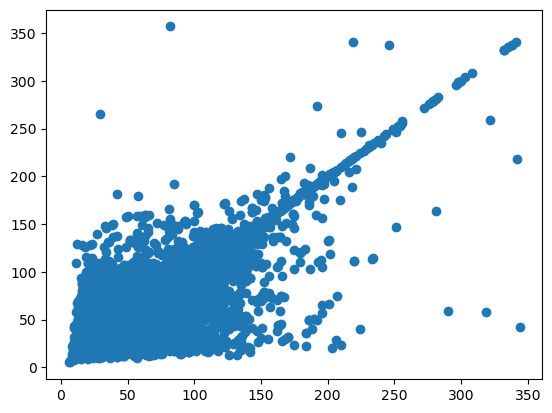

In [72]:
plt.scatter(truth_start,pred_start)

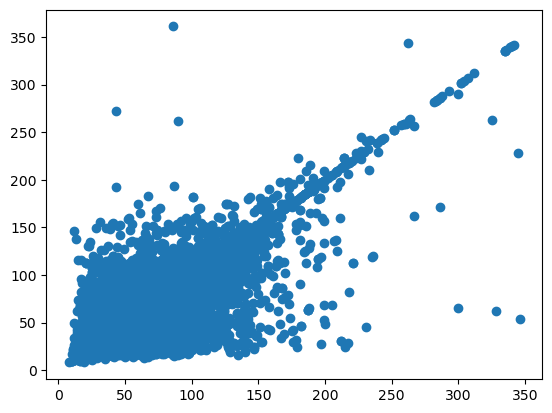

In [73]:
plt.scatter(truth_end,pred_end)

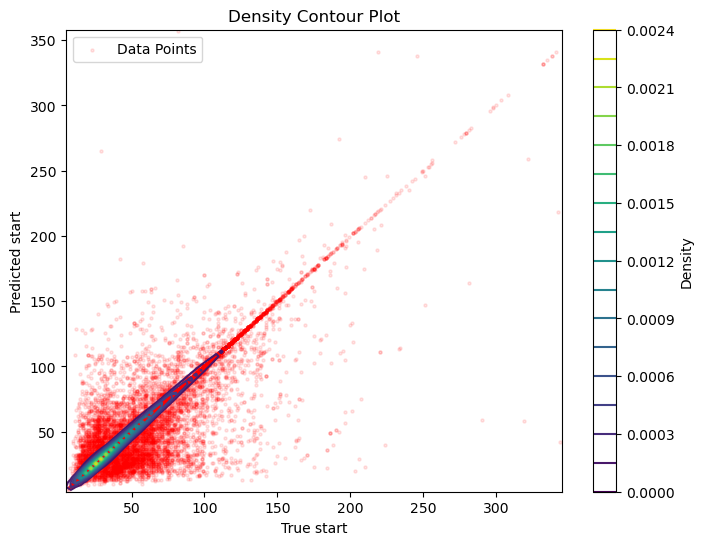

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Example data
list1 = np.array(truth_start)  # Replace with your data
list2 = np.array(pred_start)  # Replace with your data

# Create a 2D KDE (kernel density estimate)
xy = np.vstack([list1, list2])
kde = gaussian_kde(xy)

# Define grid for evaluation
x_min, x_max = list1.min() - 1, list1.max() + 1
y_min, y_max = list2.min() - 1, list2.max() + 1
x_grid, y_grid = np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])

# Evaluate KDE on grid
Z = kde(positions).reshape(X.shape)

# Create contour plot
plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, levels=20, cmap='viridis')  # Filled contours
plt.colorbar(label='Density')
plt.scatter(list1, list2, s=5, color='red', alpha=0.1, label='Data Points')
plt.xlabel('True start')
plt.ylabel('Predicted start')
plt.title('Density Contour Plot')
plt.legend()
plt.show()


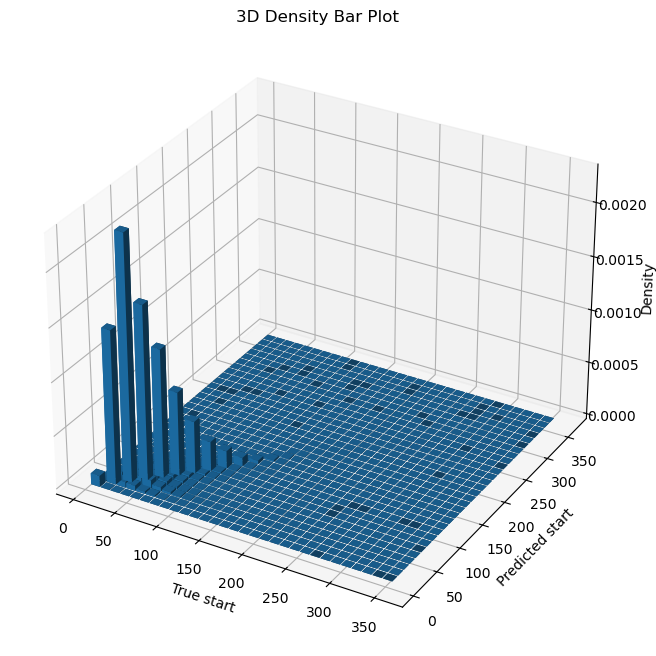

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# Example data
list1 = np.array(truth_start)  # Replace with your data
list2 = np.array(pred_start)  # Replace with your data

# Create a 2D KDE (kernel density estimate)
xy = np.vstack([list1, list2])
kde = gaussian_kde(xy)

# Define grid for evaluation
x_min, x_max = list1.min() - 1, list1.max() + 1
y_min, y_max = list2.min() - 1, list2.max() + 1
x_grid, y_grid = np.linspace(x_min, x_max, 30), np.linspace(y_min, y_max, 30)  # Coarser grid for bar plot
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])

# Evaluate KDE on grid
Z = kde(positions).reshape(X.shape)

# Create 3D bar plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create bars
xpos, ypos = X.ravel(), Y.ravel()
zpos = np.zeros_like(xpos)
dx = dy = (x_grid[1] - x_grid[0]) * 0.9  # Bar width (adjust for spacing)
dz = Z.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, cmap='viridis')

# Add labels
ax.set_xlabel('True start')
ax.set_ylabel('Predicted start')
ax.set_zlabel('Density')
ax.set_title('3D Density Bar Plot')
plt.show()


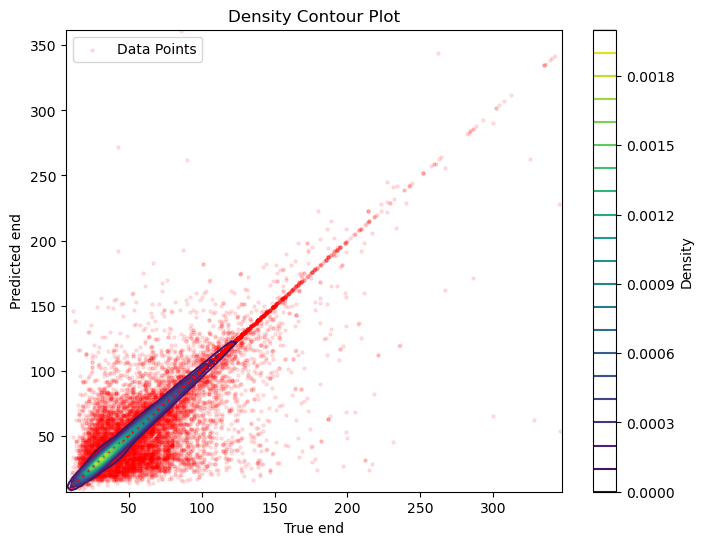

In [76]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Example data
list1 = np.array(truth_end)  # Replace with your data
list2 = np.array(pred_end)  # Replace with your data

# Create a 2D KDE (kernel density estimate)
xy = np.vstack([list1, list2])
kde = gaussian_kde(xy)

# Define grid for evaluation
x_min, x_max = list1.min() - 1, list1.max() + 1
y_min, y_max = list2.min() - 1, list2.max() + 1
x_grid, y_grid = np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])

# Evaluate KDE on grid
Z = kde(positions).reshape(X.shape)

# Create contour plot
plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, levels=20, cmap='viridis')  # Filled contours
plt.colorbar(label='Density')
plt.scatter(list1, list2, s=5, color='red', alpha=0.1, label='Data Points')
plt.xlabel('True end')
plt.ylabel('Predicted end')
plt.title('Density Contour Plot')
plt.legend()
plt.show()


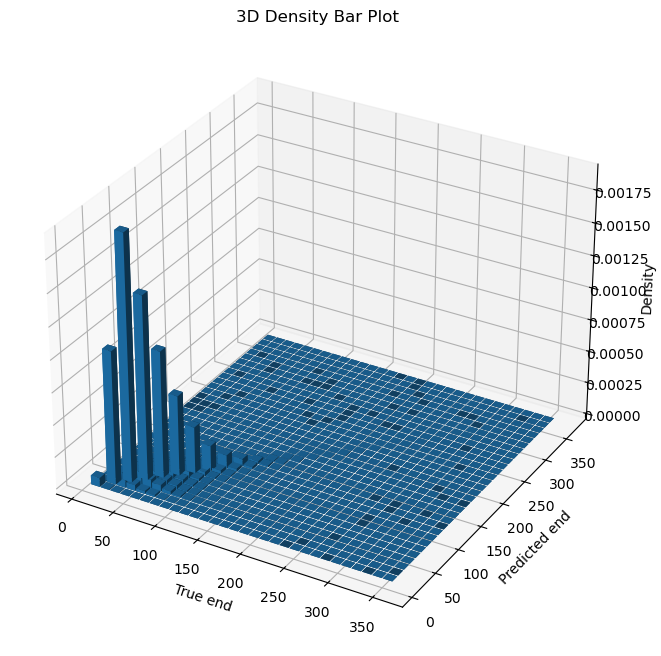

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# Example data
list1 = np.array(truth_end)  # Replace with your data
list2 = np.array(pred_end)  # Replace with your data

# Create a 2D KDE (kernel density estimate)
xy = np.vstack([list1, list2])
kde = gaussian_kde(xy)

# Define grid for evaluation
x_min, x_max = list1.min() - 1, list1.max() + 1
y_min, y_max = list2.min() - 1, list2.max() + 1
x_grid, y_grid = np.linspace(x_min, x_max, 30), np.linspace(y_min, y_max, 30)  # Coarser grid for bar plot
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])

# Evaluate KDE on grid
Z = kde(positions).reshape(X.shape)

# Create 3D bar plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create bars
xpos, ypos = X.ravel(), Y.ravel()
zpos = np.zeros_like(xpos)
dx = dy = (x_grid[1] - x_grid[0]) * 0.9  # Bar width (adjust for spacing)
dz = Z.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, cmap='viridis')

# Add labels
ax.set_xlabel('True end')
ax.set_ylabel('Predicted end')
ax.set_zlabel('Density')
ax.set_title('3D Density Bar Plot')
plt.show()


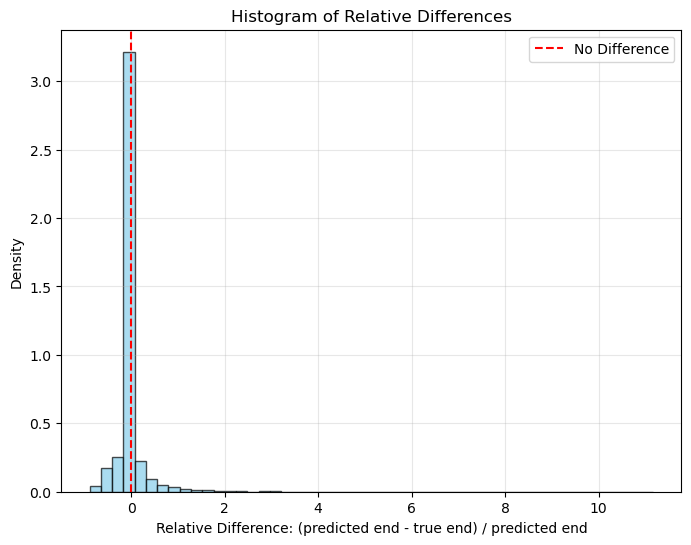

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
list1 = np.array(truth_end)  # Replace with your data
list2 = np.array(pred_end)  # Replace with your data

# Calculate relative differences
relative_diff = (list2 - list1) / list1

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(relative_diff, bins=50, color='skyblue', edgecolor='black', alpha=0.7, density=True)
plt.axvline(x=0, color='red', linestyle='--', label='No Difference')
plt.xlabel('Relative Difference: (predicted end - true end) / predicted end')
plt.ylabel('Density')
plt.title('Histogram of Relative Differences')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


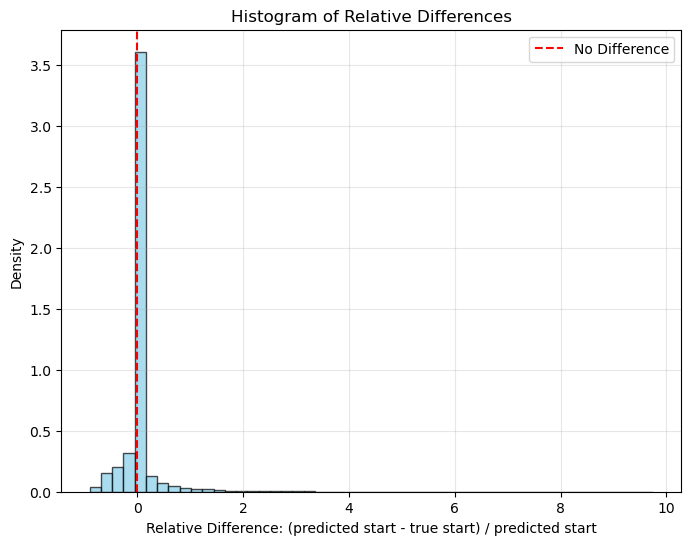

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
list1 = np.array(truth_start)  # Replace with your data
list2 = np.array(pred_start)  # Replace with your data

# Calculate relative differences
relative_diff = (list2 - list1) / list1

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(relative_diff, bins=50, color='skyblue', edgecolor='black', alpha=0.7, density=True)
plt.axvline(x=0, color='red', linestyle='--', label='No Difference')
plt.xlabel('Relative Difference: (predicted start - true start) / predicted start')
plt.ylabel('Density')
plt.title('Histogram of Relative Differences')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
